#  $\Delta\Sigma$ in  `UniverseMachine` from pre-computed pairs

### Method 

For a fixed choice of `rp_bins`, we can pre-compute the total amount of mass in cylinders surrounding each model galaxy, storing the result as an array of shape $(N_{\rm gals}, N_{\rm rp\_bins}).$ Once we have this 2d array, we can then compute $\Delta\Sigma$ for subsamples of the $N_{\rm gals}$ galaxies simply by masking on the subsample whose lensing signal we want. This means that once we have done our pre-computation in advance (possibly even writing the result to disk), we can go on to calculate the $\Delta\Sigma$ of any subsample of these galaxies more or less instantaneously. 

These notes show how to do that on the `UniverseMachine` mocks.

In [18]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

from time import time

import numpy as np
import matplotlib.pyplot as plt

from halotools.sim_manager import CachedHaloCatalog
from halotools.mock_observables import delta_sigma_from_precomputed_pairs

from umachine_pyio.load_mock import value_added_mock, load_mock_from_binaries

from model_predictions import precompute_lensing_pairs

%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Retrieve particle data

Right now this comes from `Bolshoi-Planck` at $z=0,$ but eventually this will come from `MDPL2`

In [1]:
halocat = CachedHaloCatalog(simname='bolplanck', redshift=0)

particles = halocat.ptcl_table
particle_masses = halocat.particle_mass

total_num_ptcl_in_snapshot = (halocat.num_ptcl_per_dim ** 3)
downsampling_factor = total_num_ptcl_in_snapshot / float(len(particles))
print("# The downsampling factor is: %11.6f" % downsampling_factor)

# The downsampling factor is: 8589.934592


### Retrieve `UniverseMachine` data

The `dirname` needs to be set to the disk location where you have stored your binary collection. You will also need the `umachine_pyio` package installed, which you can get from [my UniverseMachine python repo](https://github.com/aphearin/umachine_pyio.git). 

Right now all the `umachine_pyio` repo does is load the data into a mock with a few convenient value-added columns, but eventually I'll collect my analysis tools into a `pip` installable package that does quite a bit more. 

In [4]:
# Location of the data

#dirname = "/Users/aphearin/work/UniverseMachine/data/0412_binaries/obs_sm_9p75_cut/a_1.002310"
# This is for Song Huang
dirname = "Data/a_1.002310/"

subvolumes = np.arange(144)

galprops = list((
    'sm', 'sfr', 'obs_sm', 'obs_sfr', 'icl', 'halo_id', 'upid',
    'x', 'y', 'z', 'vx', 'vy', 'vz', 'rvir', 'mvir', 'mpeak'))

gals = value_added_mock(
    load_mock_from_binaries(dirname, subvolumes, galprops), 
    halocat.Lbox[0])

Total runtime = 24.31 seconds


### Making a cut on the sample of galaxies for the pre-compute

Since we're going to be mapping new values $M_{\ast, 100}^{\rm new}$ onto the `UniverseMachine` mocks in an MCMC context, then in principle we should do our pre-compute for the *entire* mock catalog. In practice, this will be quite slow (tens of minutes when using $10^{6}$ DM particles in the `Bolshoi-Planck` box). So to speed things up, we can easily throw out all galaxies with $M_{\ast}<10^{10.5}M_{\odot},$ since it's not likely that our remapping is going to upscatter many (any) galaxies below this original mass into our sample of $M_{\ast, 100}^{\rm new} \gtrsim 10^{11.6}M_{\odot}.$ 

For a $M_{\ast}<10^{10.5}M_{\odot}$ cut on the `Bolshoi-Planck` mocks, and computing lensing out to $30 {\rm Mpc/h},$ this still takes a few minutes. So the code below implements a $10^{11.5}$ cut just to temporarily cut down on notebook execution time during code verification steps. But this should be set to a lower value when doing the pre-compute that actually gets passed to MCMC walkers. 

In [6]:
stellar_mass_cut = (10**11.5)

sample = gals[gals['sm'] > stellar_mass_cut]

rp_bins = np.logspace(-1.0, 1.5, 20)
period = halocat.Lbox[0]

start = time()
mass_encl = precompute_lensing_pairs(
    sample['x'], sample['y'], sample['z'], 
    particles['x'], particles['y'], particles['z'],
    particle_masses, downsampling_factor, 
    rp_bins, period)
end = time()
runtime = end-start 
num_sample = len(sample)
num_ptcl = len(particles)

msg = "Total runtime for {0} galaxies and {1:.1e} particles = {2:.2f} seconds"
print(msg.format(num_sample, num_ptcl, runtime))

#  Total runtime for 4229 galaxies and 1.0e+06 particles = 6.49 seconds
# Total runtime for 14312 galaxies and 1.0e+06 particles = 26.12 seconds
#  Total runtime for 37912 galaxies and 1.0e+06 particles = 55.05 seconds
# Total runtime for 132837 galaxies and 1.0e+06 particles = 211.19 seconds

Total runtime for 4229 galaxies and 1.0e+06 particles = 4.31 seconds


In [8]:
mass_encl.shape

(4229, 20)

### Computing $\Delta\Sigma$ for subsamples 

Now let's use our pre-computed pairs result to predict the lensing for a few different subsamples of our model galaxies. We do this just by writing down any `Numpy` boolean mask array, and passing that mask to the `delta_sigma_from_precomputed_pairs` function in `Halotools`.

Let's start off by calculating the lensing around all galaxies with $M_{\rm \ast, bcg} + M_{\rm \ast, icl} > 10^{12}M_{\odot}.$ When we actually run the MCMC, these subsamples will be defined by their values of $M_{\rm \ast, 10}^{\rm new}$ and $M_{\rm \ast, 100}^{\rm new}.$ For this demo we'll just make cuts on $M_{\rm \ast, 10}^{\rm orig}$ and $M_{\rm \ast, 100}^{\rm orig}.$

In [10]:
#  Define the subsample mask
mask = sample['sm'] + sample['icl'] > (10**12)

subsample = sample[mask]

#  Use the mask to get subsample positions and pre-computed pairs
subsample_positions = np.vstack([sample['x'][mask], sample['y'][mask], sample['z'][mask]]).T
subsample_mass_encl_precompute = mass_encl[mask, :]

rp_ht_units, ds_ht_units = delta_sigma_from_precomputed_pairs(
    subsample_positions, 
    subsample_mass_encl_precompute, 
    rp_bins, period, 
    cosmology=halocat.cosmology)

Output `ds_ht_units` is in the usual `Halotools` comoving units of $(M_{\odot}/h)/({\rm Mpc/h})^2.$ So we first convert to comoving $M_{\odot}/{\rm pc}^2$ by multiplying the `ds_ht_units` result by $1 / (h*1e12).$ 

And we multiply by $(1 + z)^2$ to convert from comoving to physical units. We also convert `rp_ht_units` from comoving ${\rm Mpc}/h$ units into physical ${\rm Mpc}$ units by multiplying by $h/(1+z).$ 

In [11]:
halocat.cosmology.h

0.6777

In [12]:
ds_phys_msun_pc2 = (1. + halocat.redshift) ** 2 * ds_ht_units / (1e12 * halocat.cosmology.h)

rp_phys = (rp_ht_units * halocat.cosmology.h) /(1. + halocat.redshift)

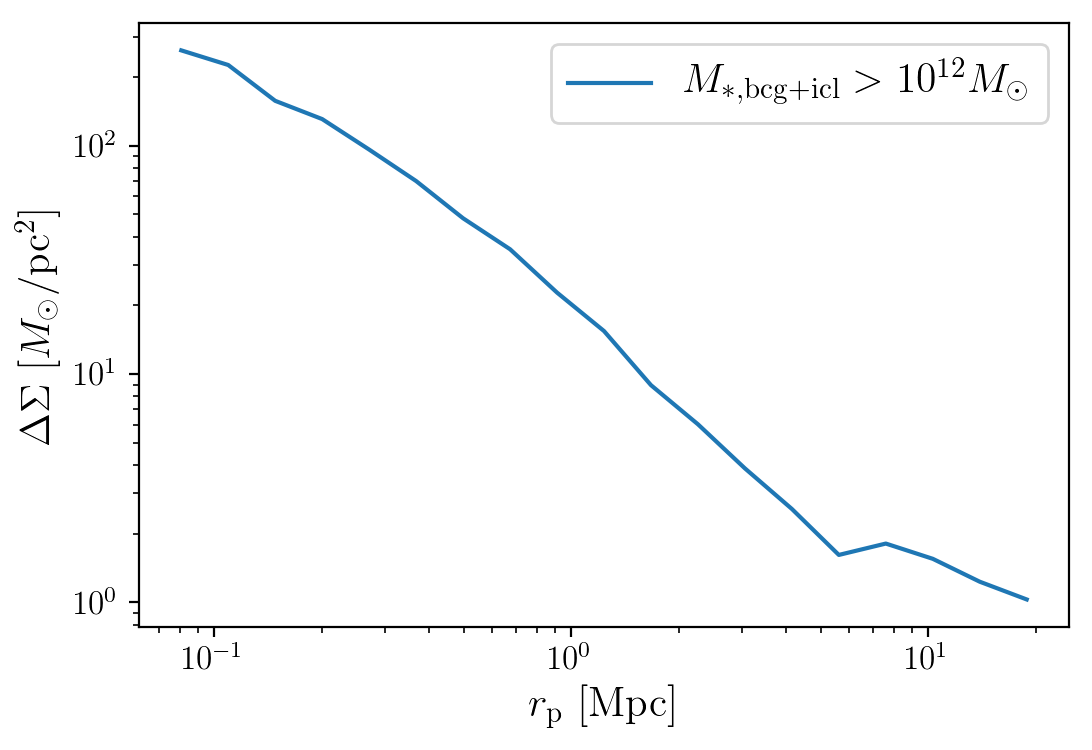

In [20]:
fig, ax = plt.subplots(1, 1)

ax.loglog()

ax.plot(rp_phys, ds_phys_msun_pc2, label=r'$M_{\rm \ast,bcg+icl}>10^{12}M_{\odot}$');

xlabel = ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', size=15);
ylabel = ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', size=15);

legend = ax.legend(fontsize=15);

### One more time

Let's do the same thing one more time for a different subsample. This time, let's look at the lensing signal for true host halos in the mass range $10^{14}M_{\odot}<M_{\rm halo}<10^{14.1}M_{\odot}.$ This example is just like the last one, but with a different mask. 

In [16]:
mask = (sample['upid'] == -1) & (sample['mvir']>10**14) & (sample['mvir']<10**14.1)
num_gals = np.count_nonzero(mask)
print("Total number of mock galaxies passing the cut = {0}".format(num_gals))

Total number of mock galaxies passing the cut = 168


In [17]:
subsample = sample[mask]
subsample_positions = np.vstack([sample['x'][mask], sample['y'][mask], sample['z'][mask]]).T
subsample_mass_encl_precompute = mass_encl[mask, :]

rp_ht_units, ds_ht_units = delta_sigma_from_precomputed_pairs(
    subsample_positions, subsample_mass_encl_precompute, 
    rp_bins, period, cosmology=halocat.cosmology)

ds_phys_msun_pc2 = (1. + halocat.redshift) ** 2 * ds_ht_units / (1e12 * halocat.cosmology.h)
rp_phys = (rp_ht_units * halocat.cosmology.h) / (1. + halocat.redshift)

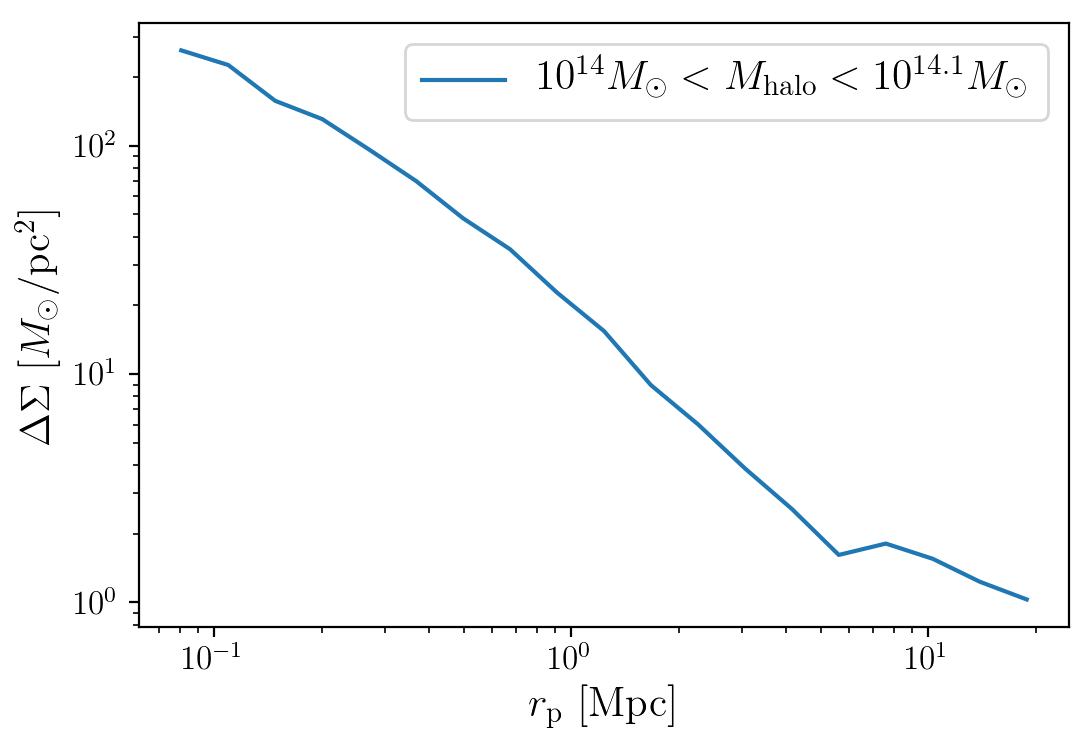

In [19]:
fig, ax = plt.subplots(1, 1)

ax.loglog()

ax.plot(rp_phys, ds_phys_msun_pc2, label=r'$10^{14}M_{\odot}<M_{\rm halo}<10^{14.1}M_{\odot}$');

xlabel = ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', size=15);
ylabel = ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', size=15);

legend = ax.legend(fontsize=15);